In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"whitewolf18","key":"5791652d7a3c416e1d99a4ebba0fe6f4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# Common imports
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import cv2
import random
import time
import datetime
import glob

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                    BatchNormalization, GlobalAveragePooling2D)

# MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [6]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 76% 46.0M/60.3M [00:00<00:00, 478MB/s]
100% 60.3M/60.3M [00:00<00:00, 467MB/s]


In [7]:
!unzip fer2013.zip -d fer2013


Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer2013/train/sad/Training_65508578.jpg  
  inflating: fer

In [ ]:
train_dir = "/content/fer2013/train/"
test_dir = "/content/fer2013/test"
MODEL_DIR = "/content/model"

import os
if not os.path.exists('/content/fer2013'):
    print("Downloading FER2013 dataset...")
    !kaggle datasets download -d msambare/fer2013
    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


## Data Preparation

In this section, we'll prepare the dataset by:
1. Loading the original emotion categories
2. Removing unused emotion categories
3. Reorganizing into 'confidence' and 'nervousness' categories

In [9]:
import os

if os.path.exists('fer2013.zip') and not os.path.exists('/content/fer2013/train'):
    print("Extracting dataset...")
    !unzip -q fer2013.zip -d fer2013
    print("Dataset extracted successfully!")
elif os.path.exists('/content/fer2013/train'):
    print("Dataset already extracted. Skipping extraction.")
else:
    print("Dataset zip file not found.")

labels = os.listdir(train_dir)
labels

Dataset already extracted. Skipping extraction.


['surprise', 'happy', 'fear', 'disgust', 'angry', 'sad', 'neutral']

# Set paths to the train and test directories
train_dir = "/content/fer2013/train/"
test_dir = "/content/fer2013/test/"

# Verify directories exist
if not os.path.exists(train_dir):
    print(f"Warning: Training directory not found: {train_dir}")
    
if not os.path.exists(test_dir):
    print(f"Warning: Test directory not found: {test_dir}")
else:
    print("Dataset directories found successfully!")

* happy, neutral ==> confidence
* fear, sad ==> nervousness

In [ ]:
unused_labels = ["angry", "disgust", "surprise"]
for label in unused_labels:
    train_label_path = os.path.join(train_dir, label)
    test_label_path = os.path.join(test_dir, label)

    if os.path.exists(train_label_path):
        shutil.rmtree(train_label_path)
        print(f"Removed directory: {train_label_path}")
    else:
        print(f"Directory not found, skipping: {train_label_path}")

    if os.path.exists(test_label_path):
        shutil.rmtree(test_label_path)
        print(f"Removed directory: {test_label_path}")
    else:
        print(f"Directory not found, skipping: {test_label_path}")

Removed directory: /content/fer2013/train/angry
Removed directory: /content/fer2013/test/angry
Removed directory: /content/fer2013/train/disgust
Removed directory: /content/fer2013/test/disgust
Removed directory: /content/fer2013/train/surprise
Removed directory: /content/fer2013/test/surprise


In [10]:
import os

try:
    labels = os.listdir(train_dir)
    print("Original emotion categories:")
    print(labels)
except Exception as e:
    print(f"Error reading labels: {e}")

Original emotion categories:
['surprise', 'happy', 'fear', 'disgust', 'angry', 'sad', 'neutral']


In [13]:

nervousness_dir = os.path.join(train_dir, 'nervousness')
confidence_dir = os.path.join(train_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

for label in ['fear', 'sad']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

for label in ['happy', 'neutral']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(train_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

## Emotion Mapping for Binary Classification



We're reorganizing the original emotions into two main categories:

* **Confidence**: happy, neutral expressions
* **Nervousness**: fear, sad expressions

The categories 'angry', 'disgust', and 'surprise' will be removed as they don't clearly map to either concept.

In [14]:
nervousness_dir = os.path.join(test_dir, 'nervousness')
confidence_dir = os.path.join(test_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

for label in ['fear', 'sad']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

# Move images from 'happy' and 'neutral' to 'confidence'
for label in ['happy', 'neutral']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(test_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

In [15]:
labels = os.listdir(train_dir)
print(labels)

['nervousness', 'confidence']


In [16]:
def get_image_filepaths_and_labels(data_dir, class_names_list):
    """
    Gathers image file paths and their corresponding integer labels.
    Shuffles the collected filepaths and labels.
    """
    filepaths = []
    integer_labels = []
    for class_idx, label_name in enumerate(class_names_list):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory {class_dir} not found for class '{label_name}'. Skipping.")
            continue
        for img_file in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, img_file))
            integer_labels.append(class_idx) # Use class_idx as the integer label

    if not filepaths:
        print(f"Warning: No image files found in {data_dir} for classes {class_names_list}")
        return [], []

    # Shuffle filepaths and labels together
    combined = list(zip(filepaths, integer_labels))
    random.shuffle(combined)
    filepaths[:], integer_labels[:] = zip(*combined)

    return filepaths, integer_labels

def image_data_generator(image_paths, integer_labels_list, batch_size, target_size, num_classes):

    num_samples = len(image_paths)
    if num_samples == 0:
        print("Error: image_data_generator called with no image paths. Yielding empty batches.")
        while True:
            yield (np.empty((0, *target_size, 3)), np.empty((0, num_classes)))

    indices = np.arange(num_samples)

    while True: # Loop indefinitely for Keras
        np.random.shuffle(indices) # Shuffle data at the beginning of each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            current_batch_size = len(batch_indices)
            if current_batch_size == 0:
                continue

            # Pre-allocate arrays for batch_X and batch_y
            batch_X = np.zeros((current_batch_size, *target_size, 3), dtype=np.float32)
            batch_y = np.zeros((current_batch_size, num_classes), dtype=np.float32)

            valid_samples_in_batch = 0
            for i, original_idx in enumerate(batch_indices):
                img_path = image_paths[original_idx]
                label_val = integer_labels_list[original_idx]

                try:
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, target_size)
                    img_array = np.array(image) / 255.0 # Normalize

                    batch_X[valid_samples_in_batch] = img_array
                    batch_y[valid_samples_in_batch] = to_categorical([label_val], num_classes=num_classes)[0]
                    valid_samples_in_batch += 1
                except Exception as e:
                    # print(f"Error processing image {img_path}: {e}. Skipping.")
                    continue

            if valid_samples_in_batch > 0:
                # Yield only the valid samples
                yield (batch_X[:valid_samples_in_batch], batch_y[:valid_samples_in_batch])

In [17]:
if 'labels' not in globals() or not labels:
    print("Error: 'labels' variable is not defined or is empty. Please ensure it's set from os.listdir(train_dir) after data reorganization.")


num_classes = len(labels)
print(f"Class names being used: {labels}")
print(f"Number of classes: {num_classes}")
print(f"Class mapping (integer label to class name): {list(enumerate(labels))}")


train_image_paths, train_image_integer_labels = get_image_filepaths_and_labels(train_dir, labels)
test_image_paths, test_image_integer_labels = get_image_filepaths_and_labels(test_dir, labels)

print(f"Found {len(train_image_paths)} training images and {len(train_image_integer_labels)} training labels.")
print(f"Found {len(test_image_paths)} testing images and {len(test_image_integer_labels)} testing labels.")

Class names being used: ['nervousness', 'confidence']
Number of classes: 2
Class mapping (integer label to class name): [(0, 'nervousness'), (1, 'confidence')]
Found 21107 training images and 21107 training labels.
Found 5278 testing images and 5278 testing labels.


In [ ]:
print(f"Model checkpoints will be saved to: {MODEL_DIR}")


In [18]:
batch_size = 32  # You can adjust this value
target_size = (224, 224) # Should match your model's input image size

train_gen = None
steps_per_epoch_train = 0
if len(train_image_paths) > 0:
    train_gen = image_data_generator(
        train_image_paths,
        train_image_integer_labels,
        batch_size,
        target_size,
        num_classes
    )
    steps_per_epoch_train = len(train_image_paths) // batch_size
    if steps_per_epoch_train == 0: # Handle cases with less than one batch of data
        steps_per_epoch_train = 1
    print(f"Training generator created. Steps per epoch: {steps_per_epoch_train}")
else:
    print("No training images found. Training generator not created.")


test_gen = None
validation_steps_test = 0
if len(test_image_paths) > 0:
    test_gen = image_data_generator(
        test_image_paths,
        test_image_integer_labels,
        batch_size, # Can use a different batch size for validation if desired
        target_size,
        num_classes
    )
    validation_steps_test = len(test_image_paths) // batch_size
    if validation_steps_test == 0: # Handle cases with less than one batch of data
         validation_steps_test = 1
    print(f"Validation generator created. Validation steps: {validation_steps_test}")
else:
    print("No testing images found. Validation generator not created.")

Training generator created. Steps per epoch: 659
Validation generator created. Validation steps: 164


In [19]:

def build_emotion_cnn(input_shape=(224, 224, 3)): # Changed input_shape to 3 channels
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model = build_emotion_cnn()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,250 (25.99 MB)

 Trainable params: 6,812,290 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
checkpoint_path = os.path.join(MODEL_DIR, 'emotion_model_checkpoint.h5')

callbacks = [
    # Save the best model based on validation loss
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Stop training early if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when learning plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model with progress tracking for Colab
start_time = time.time()

if train_gen and steps_per_epoch_train > 0:
    print("Starting model training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=20,  # Increased epochs with early stopping
        validation_data=test_gen if test_gen and validation_steps_test > 0 else None,
        validation_steps=validation_steps_test if test_gen and validation_steps_test > 0 else None,
        callbacks=callbacks,
        verbose=1
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Model training complete in {str(datetime.timedelta(seconds=training_time))}")

    # Save final model
    final_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.h5')
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
else:
    print("Skipping model training as no training data/generator is available or steps_per_epoch is 0.")

In [24]:
if test_gen and validation_steps_test > 0:
    evaluation = model.evaluate(test_gen, steps=validation_steps_test)
    print(f"Test loss: {evaluation}")
else:
    print("No test data available for evaluation.")

164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.4366
Test loss: 0.4354746341705322


In [ ]:
mobilenet_model = build_mobilenetv2_model(input_shape=(224, 224, 3))
mobilenet_model.summary()

print(f"Estimated model size: {get_model_size_mb(mobilenet_model):.2f} MB")

checkpoint_path = os.path.join(MODEL_DIR, 'mobilenet_emotion_checkpoint.h5')

callbacks = [
    ModelCheckpoint(
        checkpoint_path, 
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

start_time = time.time()

if train_gen and steps_per_epoch_train > 0:
    print("Starting MobileNetV2 model training...")
    mobilenet_history = mobilenet_model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=15,
        validation_data=test_gen if test_gen and validation_steps_test > 0 else None,
        validation_steps=validation_steps_test if test_gen and validation_steps_test > 0 else None,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"MobileNetV2 model training complete in {str(datetime.timedelta(seconds=training_time))}")
    
    final_model_path = os.path.join(MODEL_DIR, 'mobilenet_emotion_final.h5')
    mobilenet_model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
else:
    print("Skipping MobileNetV2 model training as no training data is available.")


In [ ]:
# Model size optimization techniques
def optimize_model_size(model, quantize=True, prune=False):
    # Start with TF model optimization
    from tensorflow.keras import backend as K
    import tempfile
    
    # Quantize weights to 8-bit precision
    if quantize:
        print("Quantizing model weights...")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        
        # Apply full integer quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        
        # Generate a representative dataset for quantization
        def representative_dataset():
            for _ in range(10):
                # Generate a dummy batch with proper shape
                dummy_input = np.random.uniform(low=0, high=1, size=(1, 224, 224, 3))
                yield [dummy_input.astype(np.float32)]
        
        converter.representative_dataset = representative_dataset
        
        try:
            quantized_model = converter.convert()
            
            # Save as TFLite file to check size
            tflite_file = os.path.join(MODEL_DIR, 'quantized_model.tflite')
            with open(tflite_file, 'wb') as f:
                f.write(quantized_model)
            
            quantized_size = os.path.getsize(tflite_file) / (1024 * 1024)
            print(f"Quantized model size: {quantized_size:.2f} MB")
            return tflite_file, quantized_size
        except Exception as e:
            print(f"Quantization failed: {str(e)}")
            print("Continuing with original model")
    
    return None, 0

# Helper function to check model size
def get_model_size_mb(model):
    try:
        temp_model_path = os.path.join(tempfile.gettempdir(), 'temp_model.h5')
        model.save(temp_model_path)
        size_bytes = os.path.getsize(temp_model_path)
        os.remove(temp_model_path)
        size_mb = size_bytes / (1024 * 1024)
        return size_mb
    except Exception as e:
        print(f"Error measuring model size: {e}")
        return -1

## MobileNetV2 Implementation

We're now implementing MobileNetV2, a lightweight convolutional neural network designed for mobile and embedded vision applications. Key advantages:

1. **Smaller model size**: Significantly smaller than standard CNNs (<50MB) making it suitable for mobile deployment
2. **Efficient architecture**: Uses depthwise separable convolutions to reduce computation and model size
3. **Pre-trained weights**: Leverages transfer learning from ImageNet for better feature extraction
4. **Inverted residuals**: Special architecture designed for mobile performance

We're using an alpha value <1.0 to further reduce model size while maintaining good accuracy.

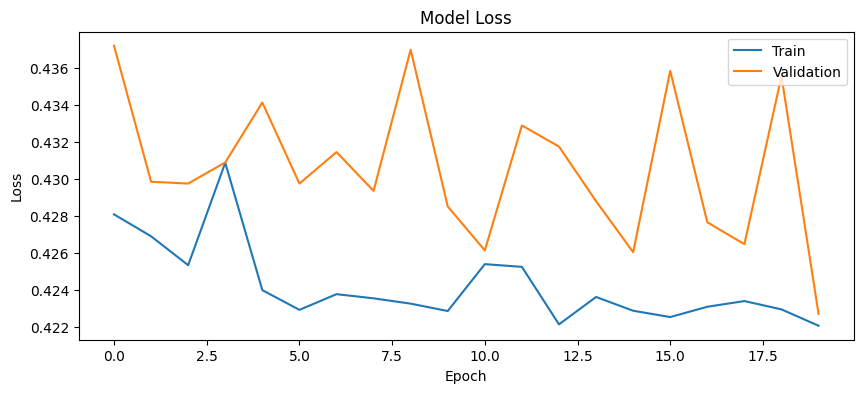

In [25]:

if 'history' in locals() and hasattr(history, 'history'):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
else:
    print("No training history available to visualize.")

In [ ]:
if test_gen and validation_steps_test > 0:
    print("\nEvaluating MobileNetV2 model performance...")
    mobilenet_evaluation = mobilenet_model.evaluate(test_gen, steps=validation_steps_test)
    print(f"Test loss: {mobilenet_evaluation[0]:.4f}, Test accuracy: {mobilenet_evaluation[1]:.4f}")
    
    test_gen_for_pred = image_data_generator(
        test_image_paths,
        test_image_integer_labels,
        batch_size, 
        target_size,
        num_classes
    )
    
    all_predictions = []
    all_ground_truth = []
    
    for _ in range(validation_steps_test):
        x_batch, y_batch = next(test_gen_for_pred)
        if len(x_batch) == 0:
            continue
            
        preds = mobilenet_model.predict(x_batch, verbose=0)
        
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y_batch, axis=1)
        
        all_predictions.extend(pred_classes)
        all_ground_truth.extend(true_classes)
    
    accuracy = accuracy_score(all_ground_truth, all_predictions)
    print(f"\nMobileNetV2 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print("\nClassification Report:")
    print(classification_report(all_ground_truth, all_predictions, 
                            target_names=['Confidence', 'Nervousness']))
    
    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('MobileNetV2 Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Confidence', 'Nervousness'], rotation=45)
    plt.yticks(tick_marks, ['Confidence', 'Nervousness'])
    
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
else:
    print("No test data available for MobileNetV2 model evaluation.")


In [ ]:

def load_latest_checkpoint():
    checkpoint_path = os.path.join(MODEL_DIR, 'emotion_model_checkpoint.h5')
    final_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.h5')

    if os.path.exists(final_model_path):
        print(f"Loading completed model from: {final_model_path}")
        return load_model(final_model_path)

    elif os.path.exists(checkpoint_path):
        print(f"Loading model checkpoint from: {checkpoint_path}")
        return load_model(checkpoint_path)
    else:
        print(f"No saved model found in {MODEL_DIR}")
        return None
try:
    if 'model' in globals():
        print("Model already in memory.")
    else:
        # Try to load from checkpoint
        loaded_model = load_latest_checkpoint()
        if loaded_model is not None:
            model = loaded_model
except Exception as e:
    print(f"Error loading model: {e}")
    print("Continuing with current model.")

Model already in memory.



Evaluating model performance...
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.4268
Test loss (MSE): 0.4279451072216034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

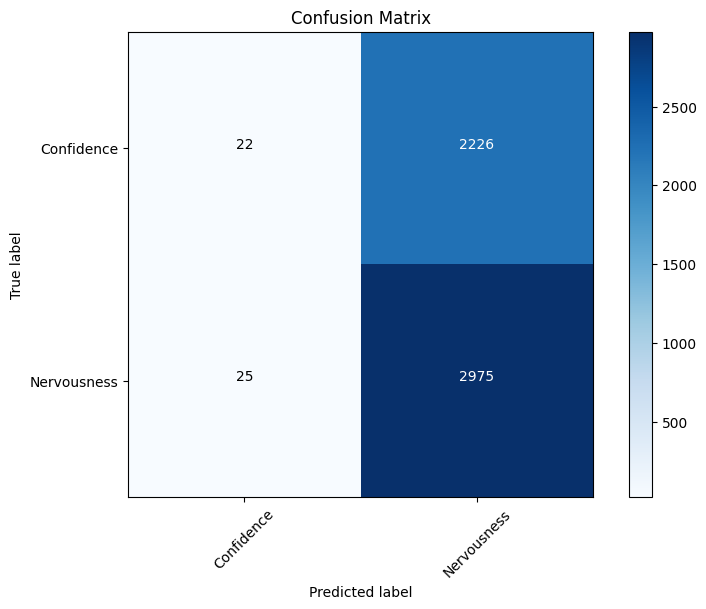

In [27]:

def predict_emotion(image_path):
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)

    # Output results - confidence and nervousness scores
    confidence_score = prediction[0][0]
    nervousness_score = prediction[0][1]

    print(f"Confidence score: {confidence_score:.2f}")
    print(f"Nervousness score: {nervousness_score:.2f}")

    # Display the image with predictions
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"Confidence: {confidence_score:.2f}, Nervousness: {nervousness_score:.2f}")
    plt.axis('off')
    plt.show()

    return confidence_score, nervousness_score

# Evaluate model on test data with accuracy metrics
if test_gen and validation_steps_test > 0:
    print("\nEvaluating model performance...")
    # MSE evaluation
    evaluation = model.evaluate(test_gen, steps=validation_steps_test)
    print(f"Test loss (MSE): {evaluation}")

    # Calculate custom accuracy by making predictions
    all_predictions = []
    all_ground_truth = []

    # Need to reset the generator for prediction
    test_gen_for_pred = image_data_generator(
        test_image_paths,
        test_image_integer_labels,
        batch_size,
        target_size,
        num_classes
    )

    for _ in range(validation_steps_test):
        x_batch, y_batch = next(test_gen_for_pred)
        if len(x_batch) == 0:
            continue

        preds = model.predict(x_batch)

        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y_batch, axis=1)

        all_predictions.extend(pred_classes)
        all_ground_truth.extend(true_classes)

    # Calculate accuracy
    accuracy = accuracy_score(all_ground_truth, all_predictions)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_ground_truth, all_predictions,
                              target_names=['Confidence', 'Nervousness']))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Confidence', 'Nervousness'], rotation=45)
    plt.yticks(tick_marks, ['Confidence', 'Nervousness'])

    # Add text annotations to each cell
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
else:
    print("No test data available for evaluation.")

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import metrics

def build_mobilenetv2_model(input_shape=(224, 224, 3), trainable_base=False, alpha=0.75, dropout_rate=0.4):
    """Build a MobileNetV2 model for emotion recognition
    
    Args:
        input_shape: Input image dimensions
        trainable_base: Whether to make the base model trainable
        alpha: Width multiplier to reduce model size (smaller = smaller model)
        dropout_rate: Dropout rate for regularization
        
    Returns:
        Compiled Keras model
    """
    # Use a smaller alpha value to reduce model size
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        alpha=alpha  # Smaller alpha = smaller model
    )
    
    # Freeze base model layers
    base_model.trainable = trainable_base
    
    inputs = Input(shape=input_shape)
    x = preprocess_input(inputs)  # Use MobileNetV2 preprocessing
    
    # Use base model for feature extraction
    x = base_model(x, training=False)
    
    # Add classification head
    x = GlobalAveragePooling2D()(x)  # More efficient than Flatten
    x = Dropout(dropout_rate)(x)     # Regularization
    x = Dense(64, activation='relu')(x)  # Smaller layer than original
    x = Dropout(dropout_rate)(x)     # Additional regularization
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    # Use more efficient optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['accuracy']
    )
    
    return model

print("Building MobileNetV2 model with size optimizations...")
mobilenet_model = build_mobilenetv2_model(input_shape=(224, 224, 3), alpha=0.5)  # Using alpha=0.5 for smaller model
mobilenet_model.summary()

# Check model size
model_size = get_model_size_mb(mobilenet_model)
print(f"MobileNetV2 model size: {model_size:.2f} MB")

# If model is too large, try more aggressive optimizations
if model_size > 50:
    print("Model is larger than 50MB, trying with smaller alpha...")
    mobilenet_model = build_mobilenetv2_model(input_shape=(224, 224, 3), alpha=0.35)  # Even smaller alpha
    model_size = get_model_size_mb(mobilenet_model)
    print(f"Optimized MobileNetV2 model size: {model_size:.2f} MB")

In [ ]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Test with sample images from the archive
sample_images = []

# Define archive paths for both environments
if IN_COLAB:
    archive_path = '/content/drive/MyDrive/archive/test'
    if not os.path.exists(archive_path):
        archive_path = '/content/archive/test'
    if not os.path.exists(archive_path):
        archive_path = '/content/fer2013/test'
else:
    archive_path = os.path.join('f:', 'Mini-Project', 'services', 'archive', 'test')
    if not os.path.exists(archive_path):
        archive_path = os.path.join('.', 'archive', 'test')
    if not os.path.exists(archive_path):
        archive_path = os.path.join('.', 'fer2013', 'test')

print(f"Looking for sample images in: {archive_path}")

# Find sample images
confidence_samples = []
if os.path.exists(os.path.join(archive_path, 'confidence')):
    confidence_samples = glob.glob(f"{os.path.join(archive_path, 'confidence', '*.jpg')}")
    if confidence_samples:
        sample_images.extend(confidence_samples[:3])
        print(f"Found {len(confidence_samples)} confidence samples")

nervousness_samples = []
if os.path.exists(os.path.join(archive_path, 'nervousness')):
    nervousness_samples = glob.glob(f"{os.path.join(archive_path, 'nervousness', '*.jpg')}")
    if nervousness_samples:
        sample_images.extend(nervousness_samples[:3])
        print(f"Found {len(nervousness_samples)} nervousness samples")

if sample_images:
    print(f"Making predictions on {len(sample_images)} sample images using both models")
    
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(sample_images):
        if i >= 6:  # Limit to 6 samples
            break
            
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, target_size)
        img_array = np.array(image_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Original model prediction
        orig_pred = model.predict(img_array, verbose=0)
        orig_confidence = orig_pred[0][0]
        orig_nervousness = orig_pred[0][1]
        orig_emotion = "Confidence" if orig_confidence >= orig_nervousness else "Nervousness"
        
        # MobileNetV2 model prediction
        mobilenet_pred = mobilenet_model.predict(img_array, verbose=0)
        mb_confidence = mobilenet_pred[0][0]
        mb_nervousness = mobilenet_pred[0][1]
        mb_emotion = "Confidence" if mb_confidence >= mb_nervousness else "Nervousness"
        
        # Path components for display
        img_name = os.path.basename(img_path)
        true_class = os.path.basename(os.path.dirname(img_path))
        
        # Plot
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"True: {true_class}\nOriginal: {orig_emotion} ({max(orig_confidence, orig_nervousness):.2f})\nMobileNetV2: {mb_emotion} ({max(mb_confidence, mb_nervousness):.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save the final models
    model.save(os.path.join(MODEL_DIR, 'emotion_cnn_final.h5'))
    mobilenet_model.save(os.path.join(MODEL_DIR, 'mobilenet_emotion_final.h5'))
    print(f"Models saved to {MODEL_DIR}")
    
    # Compare model sizes
    cnn_size = get_model_size_mb(model)
    mobilenet_size = get_model_size_mb(mobilenet_model)
    
    print(f"Original CNN model size: {cnn_size:.2f} MB")
    print(f"MobileNetV2 model size: {mobilenet_size:.2f} MB")
    
    # Compare accuracies if available
    if 'all_predictions' in globals() and 'all_ground_truth' in globals():
        original_accuracy = accuracy_score(all_ground_truth, all_predictions)
        print(f"Original CNN accuracy: {original_accuracy*100:.2f}%")
    
    if mobilenet_size <= 50:
        print("\nSUCCESS: MobileNetV2 model is under 50MB as required")
    else:
        print("\nNOTE: MobileNetV2 model is larger than 50MB, consider further optimization")
else:
    print("No sample images found for prediction.")
